## Purporse

Explore how to create good clusters using GMM and Kmeans and exploring:

- Efficiency (how fast they run)
- How they cluster differen

In [1]:
import os
os.environ['OMP_NUM_THREADS'] = "6"
print(os.environ['OMP_NUM_THREADS'])

6


In [2]:
# import libraries

# the basic ones
import numpy as np
import pandas as pd

# Model
from sklearn.ensemble import RandomForestRegressor

# pipeline and column trasnformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Imputing numerical data
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

# we will use this one (for categorical columns) to lower the amount of columns and work a little faster
from sklearn.preprocessing import TargetEncoder

# plotting libraries
import matplotlib.pyplot as plt
import plotly.express as px

# To plot clusters in lower dimension
from sklearn.manifold import TSNE

# new library, we haven't used this one before in this repo
from sklearn.mixture import GaussianMixture 
from sklearn.metrics import silhouette_score

In [3]:
# Read the data
# This data you can find here: https://www.kaggle.com/c/home-data-for-ml-course/data

X_full = pd.read_csv('train.csv', index_col='Id')

# SalePrice is the target, if there is no target eliminate row associated with it
X_full.dropna(axis=0, subset=['SalePrice'], inplace=True)
prices = X_full.SalePrice
X = X_full.copy()
X.drop(['SalePrice'], axis=1, inplace=True)

In [45]:
def transforming_clustering_gmm(X,y,n_components=3):
    
   # for Kmeans very useful to scale data. 
    columns_X = X.columns
    numerical_col = [col for col in X.columns if str(X[col].dtypes)!='object' ]
    categorical_col = [col for col in X.columns if str(X[col].dtypes)=='object' ]
    

    numerical_transformer = Pipeline(
    steps=[("scaler1", StandardScaler()), ("imputer", KNNImputer(n_neighbors=3))
      ]
        )
    
    categorical_transformer =  Pipeline(steps=[
        ('encoder',TargetEncoder(smooth="auto",target_type='continuous')),
        ("scaler2", StandardScaler())
    ])

    preprocessor = ColumnTransformer(transformers=
        [("numerical_transformer", numerical_transformer, numerical_col),
        ("categorical_transformer", categorical_transformer, categorical_col)],remainder='passthrough')

    gmm = GaussianMixture(n_components = n_components,max_iter=500,n_init=3) 
    # Bundle preprocessing and modeling code in a pipeline
    #pipe = Pipeline(steps=[('preprocessor', preprocessor)])
    
    # we need y because of TargetEncoder
    X_transform = preprocessor.fit_transform(X,y)
    gmm.fit(X_transform)
    df_transform = pd.DataFrame(X_transform,columns=columns_X)
    df_transform['clusters'] = gmm.predict(X_transform)
    df_transform_unscale = df_transform.copy()
    df_transform_unscale[numerical_col] = preprocessor.named_transformers_["numerical_transformer"].named_steps["scaler1"].inverse_transform(df_transform_unscale[numerical_col])
    df_transform_unscale[categorical_col] = preprocessor.named_transformers_["categorical_transformer"].named_steps["scaler2"].inverse_transform(df_transform_unscale[categorical_col])
    
    return  df_transform, df_transform_unscale, gmm

In [46]:
# I try very high number of cluster but we see that it just decrease.
import time
start_time = time.time()
number_clusters = [a for a in range(2,7)]
sil_list = []
silhoette_max = 0
index_max = -1
counter = 0
for clusters in number_clusters:
    df_transform, df_transform_unscale, gmm = transforming_clustering_gmm(X,prices,n_components=clusters)
    columns_without_clusters = [x for x in df_transform.columns if x not in ['clusters']]
    silhoette = silhouette_score(df_transform[columns_without_clusters],df_transform['clusters'])
    if silhoette > silhoette_max:
        silhoette_max = silhoette
        index_max = counter 
    counter = counter + 1
    sil_list.append(silhoette)

print(f" Seconds to run: {(time.time() - start_time)}")

 Seconds to run: 4.445001602172852


 the best score is with 0.14 with 2 number or clusters 


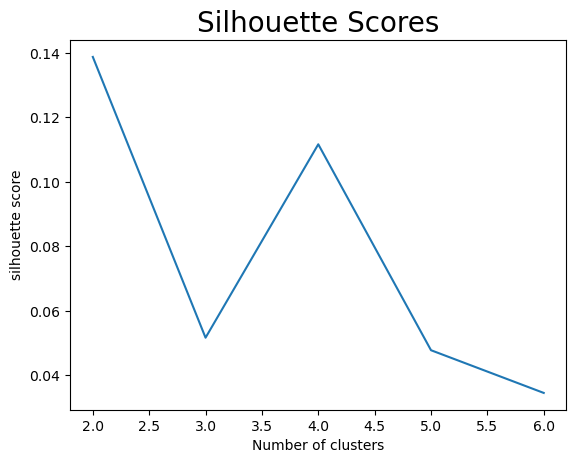

In [47]:
plt.plot(number_clusters, sil_list, '-')
plt.title("Silhouette Scores", fontsize=20)
plt.xlabel("Number of clusters")
plt.ylabel("silhouette score")
print(f" the best score is with {round(silhoette_max,2)} with {number_clusters[index_max]} number or clusters ")

Notice the score is very low. When the score is near to 0 that means that the points could have been easily in another cluster. The maximum value that we could at have is 1. Remeber also that in the previous notebook we saw that the tsne didn't show well define clusters. We are going to plot this graph again but instead that doing against prices or "y" we are going to use the clusters.

But all the same we are going to explore how good are really this clusters.


In [48]:
# we use the best number of clusters we got so far
df_transform, df_transform_unscale, gmm = transforming_clustering_gmm(X,prices,n_components=number_clusters[index_max])
# Let us use T-SNE that we use in the previous notebook to see how this cluster are doing.
tsne = TSNE(n_components=2,perplexity=5, random_state=42,learning_rate=1000,n_iter=5000)
X_tsne = tsne.fit_transform(df_transform)

In [59]:
X_tsne = tsne.fit_transform(df_transform)
fig = px.scatter(x=X_tsne[:, 0], y=X_tsne[:, 1], color=df_transform['clusters'])
fig.update_layout(
    title="t-SNE house price visualization",
    xaxis_title="First t-SNE",
    yaxis_title="Second t-SNE",
)
fig.show()
# images save in this folder
#fig.write(f"(2) GMM_tsne with 2 clusters.png")

So, good news! In a lower dimension done with T-SNE we can see that clusters are generally clump together.
So we need to know a little more now, for instance:
+ Giving some important feautures, how does each cluster center upon them?
+ do this clusters have statistical difference in the prices between each group?
+ What are the sizes of each cluster?